In [136]:
import sys
import os
from  argparse import Namespace
import numpy as np
import torch
import cv2
from PIL import Image
import plotly.graph_objects as go
import matplotlib

# img transforms
from torchvision.transforms import Resize, InterpolationMode
from torchvision.transforms.functional import to_pil_image

# path hack
sys.path.insert(0, os.path.abspath("libs/DLNR"))
ROOT = os.path.abspath(".")

%load_ext autoreload
%autoreload 2

print(f'Cuda status:{torch.cuda.is_available()}')
colormap = matplotlib.colormaps.get_cmap('turbo')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Cuda status:True


In [137]:
from libs.DLNR.core.dlnr import DLNR, autocast
from libs.DLNR.core.utils.utils import InputPadder
from libs.DLNR.core.utils import frame_utils

#### Model Args

In [140]:
args = {
    # Path to checkpoint file to restore
    "restore_ckpt": f"{ROOT}/weights/DLNR_SceneFlow.pth",   # default: '/your_path/dlnr.pth'

    # Use mixed precision
    "mixed_precision": False,                 # default: True

    # Number of flow-field updates during forward pass
    "valid_iters": 16,                       # default: 10

    # ---- Architecture choices ----
    # Hidden state and context dimensions
    "hidden_dims": [128, 128, 128],          # default: [128, 128, 128]

    # Correlation volume implementation
    # choices: ["reg", "reg_cuda"]
    "corr_implementation": "reg",       # default: 'reg_cuda' - requires additional build

    # Use a single backbone for the context and feature encoders
    "shared_backbone": True,                 # default: True

    # Number of levels in the correlation pyramid
    "corr_levels": 4,                        # default: 4

    # Width of the correlation pyramid
    "corr_radius": 4,                        # default: 4

    # Resolution of the disparity field (1/2^K)
    "n_downsample": 2,                       # default: 2

    # Iterate the low-res GRUs more frequently
    "slow_fast_gru": False,                  # default: False (flag)

    # Number of hidden GRU levels
    "n_gru_layers": 3,                       # default: 3
}
args = Namespace(**args)

#### Model load

In [141]:
model = torch.nn.DataParallel(DLNR(args), device_ids=[0])
if args.restore_ckpt is not None:
    assert args.restore_ckpt.endswith(".pth")
    checkpoint = torch.load(args.restore_ckpt)
    model.load_state_dict(checkpoint, strict=True)
    print("Done loading checkpoint")
else:
    print('Model was not initiated from checkpoint')

num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"The model has {format(num_params / 1e6, '.2f')}M learnable parameters.")

model.cuda()
model.eval();

Done loading checkpoint
The model has 57.38M learnable parameters.


#### Image load

T typical `StereoDataset` calls return:

|  | Name    | Shape       | Type          | Description                                    |
| - | ------- | ----------- | ------------- | ---------------------------------------------- |
| 1 | `paths` | —           | list[str]     | `[left_img_path, right_img_path, disp_path]`   |
| 2 | `img1`  | `[3, H, W]` | `FloatTensor` | Left image, 0–255, padded if `img_pad` set     |
| 3 | `img2`  | `[3, H, W]` | `FloatTensor` | Right image, same as `img1`                    |
| 4 | `flow`  | `[1, H, W]` | `FloatTensor` | Horizontal flow `u = -disp`    |
| 5 | `valid` | `[H, W]`    | `FloatTensor` | Valid-pixel mask (`disp < 512` or from reader) |

If `img` is grayscale, it’s tiled to 3 channels.
The horizonal component `(u)` of the flow tensor is the disparity. 

This is used for training & to apply the same augmentations to flow, valid and stereo images.
For inference we just need `img1` & `img2`.

##### Resizng
We have to resize as full images bloat the network and do not fit in memory. In the paper they use ~360 X 1024. I scaled in a factor of 8.

In [142]:
# init resize transform
h, w = 3008, 4112
factor = 8
h_s, w_s = round(h / factor), round(w / factor)
resize = Resize(size=(h_s, w_s), interpolation=InterpolationMode.BILINEAR, antialias=True)

In [143]:
path = '/home/jonathan/Github/FSR_DLNR/Dataset1/scan/Face_Reconstruction_log/scan000/'
number = '00125'
path1 = path + number + '_left.jpg'
path2 = path + number + '_right.jpg'

torch.Size([1, 3, 376, 514])


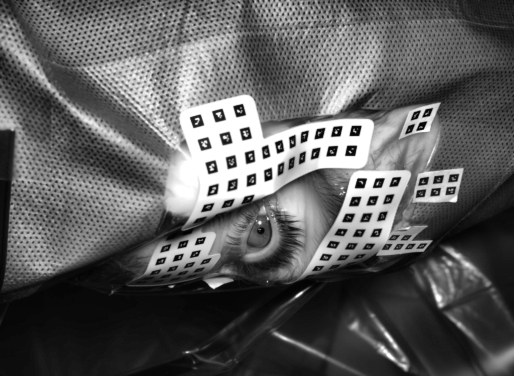

In [153]:
img1_full = frame_utils.read_gen(path1)
img2_full = frame_utils.read_gen(path2)

# resize to model size
img1_resize = resize(img1_full)
img2_resize = resize(img2_full)

# to np
img1_np = np.array(img1_resize).astype(np.uint8)
img2_np = np.array(img2_resize).astype(np.uint8)

# test?
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
img1_np = clahe.apply(img1_np)
img2_np = clahe.apply(img2_np)

# tile to 3 channels if grayscale
if len(img1_np.shape) == 2:
    img1_np = np.tile(img1_np[..., None], (1, 1, 3))
    img2_np = np.tile(img2_np[..., None], (1, 1, 3))
else:
    img1_np = img1_np[..., :3]
    img2_np = img2_np[..., :3]

img1 = torch.from_numpy(img1_np).permute(2, 0, 1).unsqueeze(0).float().cuda()
img2 = torch.from_numpy(img2_np).permute(2, 0, 1).unsqueeze(0).float().cuda()
print(img1.shape)
img1_pil = to_pil_image(img1.squeeze().byte())
img2_pil = to_pil_image(img2.squeeze().byte())
img1_pil

Add padding to make mod32

In [154]:
padder = InputPadder(img1.shape, divis_by=32)
img1, img2 = padder.pad(img1, img2)

#### Model call

In [155]:
use_mixed_precision = False # they force this in their code...
with autocast(enabled=use_mixed_precision), torch.inference_mode():
    _, flow_pr = model(img1, img2, iters=args.valid_iters, test_mode=True)

# post process: un-pad
flow_pr = padder.unpad(flow_pr.float()).cpu().squeeze(0)
# Convert to positive disparity (since flow_pr is negative)
disp = (-flow_pr[0]).cpu().numpy()

/home/jonathan/miniforge3/envs/fsr_dlnr/lib/python3.10/site-packages/torch/nn/functional.py:4215: UserWarning:

Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.



Display:

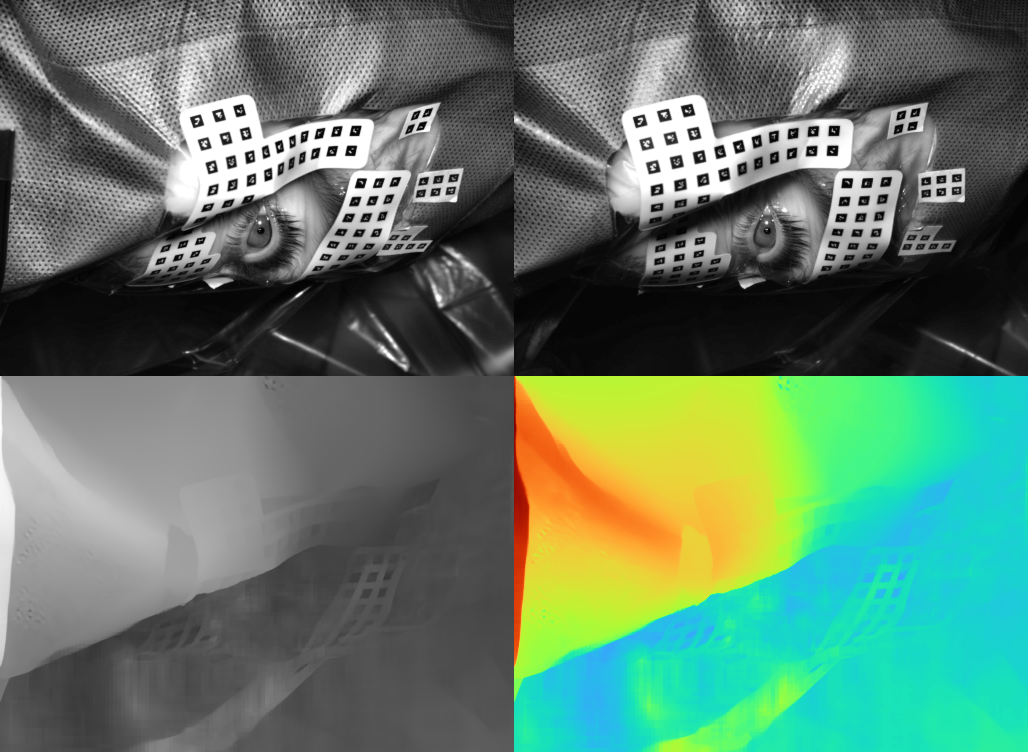

In [156]:
# normalize disparity
disp_norm = np.clip(disp / max(disp.max(), 1e-6), 0, 1)
disp_uint8 = (disp_norm * 255).astype(np.uint8)

# grayscale and color versions
disp_gray_pil = to_pil_image(disp_uint8)
disp_color = (colormap(disp_norm)[..., :3] * 255).astype(np.uint8)
disp_color_pil = Image.fromarray(disp_color)

# ensure all are RGB
img1_rgb = img1_pil.convert('RGB')
img2_rgb = img2_pil.convert('RGB')
disp_gray_pil = disp_gray_pil.convert('RGB')
disp_color_pil = disp_color_pil.convert('RGB')

# create 2x2 grid
combined = Image.new('RGB', (2 * w_s, 2 * h_s))

# top row: img1 | img2
combined.paste(img1_rgb, (0, 0))
combined.paste(img2_rgb, (w_s, 0))

# bottom row: disp_gray | disp_color
combined.paste(disp_gray_pil, (0, h_s))
combined.paste(disp_color_pil, (w_s, h_s))

display(combined)

#### Reconstruction

In [157]:
q = np.load(f"{ROOT}/Dataset1/scan/Tracking/disp_to_depth_mat.npy")
assert q.shape == (4,4)

Note that I take the factor back into account.

`TO DO`: Need to think about upscaling the disparity map in all axis? 
I just scaled the depth for now - not 100% sure

In [158]:
disp_full = cv2.resize(disp, (w,h), interpolation=cv2.INTER_LINEAR) * factor
reproj = cv2.reprojectImageTo3D(disp_full, q, handleMissingValues=True)

Sample for visualization (we have way too much points):

In [159]:
N = 100_000
points = reproj.reshape(-1, 3)
if len(points) > N:
    idx = np.random.choice(len(points), N, replace=False)
    # sample 3d points
    points = points[idx]
    # sample original image for intensity (monochrome)
    intensity = np.array(img1_full).astype(np.uint8).reshape(-1)[idx]
assert len(intensity) == len(points)

In [160]:
x, y, z = points[:,0], points[:,1], -points[:,2]
cx, cy, cz = np.mean(x), np.mean(y), np.mean(z)
r = max(np.ptp(x), np.ptp(y), np.ptp(z)) / 2 

fig = go.Figure(data=[go.Scatter3d(
    x=x, y=y, z=z,
    mode='markers',
    marker=dict(size=2, color=intensity, colorscale='gray', opacity=0.9)
)])

fig.update_layout(
    scene=dict(
        xaxis=dict(range=[cx - r, cx + r]),
        yaxis=dict(range=[cy - r, cy + r]),
        zaxis=dict(range=[cz - r, cz + r]),
        aspectmode='cube' 
    ),
    margin=dict(l=0, r=0, t=0, b=0)
)

fig.show()